In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2020spring-hw1/train.csv
/kaggle/input/ml2020spring-hw1/test.csv
/kaggle/input/ml2020spring-hw1/sample_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/ml2020spring-hw1/train.csv',encoding='big5')
print(train_data.shape)
data = train_data.iloc[:,3:]
# rainfall所在的行全部换成0
data[data == "NR"] = 0
raw_data = data.to_numpy()
# 4320 = 12*20*18
month_data = {}
for month in range(12):
    sample = np.empty([18,480])
    # 原来列的数据转移到行上面来
    for day in range(20):
        sample[:,day*24:(day+1)*24] = raw_data[18*(20*month+day):18*(20*month+day+1),:]
    month_data[month] = sample

# 每9组数据作为一个特征，原来有480组数据，现在就是471组特征数据
# 原来有18个数据特征作为1组，现在是18*9作为一组，9个小时内的特征都作为单独的
x = np.empty([12*471,18*9],dtype = float)
y = np.empty([12*471,1],dtype = float)

for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month*471+day*24+hour,:] = month_data[month][:,day*24+hour:day*24+hour+9].reshape(1,-1)
            y[month*471+day*24+hour,0] = month_data[month][9,day*24+hour+9]
            
print(x.shape,y.shape)




(4320, 27)
(5652, 162) (5652, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3089: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [3]:
# Normalization
mean_x = np.mean(x,axis=0) # 18*9
std_x = np.std(x,axis=0) # 18*9
x = (x-mean_x)/std_x

learning_rate = 100
iterators = 1000

w = np.zeros([18*9+1,1])
x = np.concatenate((np.ones([12*471,1]),x),axis=1).astype(float)

print(x.shape)

(5652, 163)


训练结束！


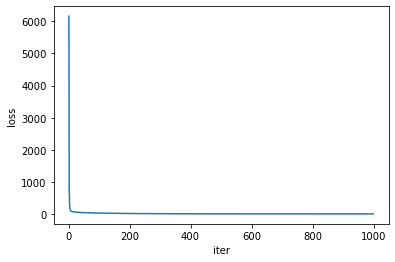

In [4]:
import matplotlib.pyplot as plt


loss_array = []
iter_array = []
eps = 1e-10
adagrad = np.zeros([18*9+1,1])
for t in range(iterators):
    loss = np.sqrt(np.sum(np.power(np.dot(x,w)-y,2))/471/12)
    if (t%100):
        loss_array.append(loss)
        iter_array.append(t)
    gradient = 2*np.dot(x.transpose(),np.dot(x,w)-y)
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

fig,ax = plt.subplots()
ax.set_xlabel('iter')
ax.set_ylabel('loss')
ax.plot(iter_array,loss_array)
np.save('weight.npy', w)
print('训练结束！')




In [5]:
# 预测数据
test_data = pd.read_csv('/kaggle/input/ml2020spring-hw1/test.csv',header=None,encoding='big5')
test_data = test_data.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
print(test_data.shape)

test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)

w = np.load('weight.npy')
ans_y = np.dot(test_x, w)

for i in range(240):
    print(['id_'+str(i),ans_y[i][0]])



(4320, 9)
['id_0', 5.174960398984744]
['id_1', 18.30621425352787]
['id_2', 20.49121809418059]
['id_3', 11.52394286980541]
['id_4', 26.61605675230614]
['id_5', 20.531348081761223]
['id_6', 21.90655101879741]
['id_7', 31.736468747068834]
['id_8', 13.391674055111721]
['id_9', 64.45646650291954]
['id_10', 20.26456883615944]
['id_11', 15.35857607736122]
['id_12', 68.58947276926722]
['id_13', 48.4281137474572]
['id_14', 18.702333824193225]
['id_15', 10.188595737466693]
['id_16', 30.74036285982043]
['id_17', 71.13221776355115]
['id_18', -4.130517391262458]
['id_19', 18.235694016428685]
['id_20', 38.57892227500776]
['id_21', 71.31151972531329]
['id_22', 7.410348162634058]
['id_23', 18.71795533032143]
['id_24', 14.937250260084557]
['id_25', 36.71973669470533]
['id_26', 17.96169700566269]
['id_27', 75.7894628721054]
['id_28', 12.30931024861446]
['id_29', 56.295351739649604]
['id_30', 25.1131608656615]
['id_31', 4.610248674094036]
['id_32', 2.483770554515033]
['id_33', 24.759422261321255]
['id_34